In [1]:
import numpy as np
import scipy.stats as ss
from numpy import Inf
import matplotlib.pyplot as plt
import sys
import pyEXP
##  exp
#sys.path.append("/u/svarel/exp/build/utils/Analysis/")
from spherical_basis_builder import *
#import simpleSL

## Auriga
import LibAu as la
import warnings
warnings.filterwarnings('ignore')

In [2]:
def empirical_potencial_profile(pos, pot, nbins=500, rmin=0, rmax=600):
    """
    Computes the number density radial profile. Assuming all the partiles have the same mass.
    """

    r_p = np.sqrt(np.sum(pos**2, axis=1))
    pot_profile = np.zeros(nbins-1)
    dr = np.linspace(rmin, rmax, nbins)
    delta_r = (dr[2]-dr[1])*0.5

    for j in range(0, len(dr)-1):
        index = np.where((r_p < dr[j+1]) & (r_p > dr[j]))[0]
        V = 4/3 * np.pi * (dr[j+1]**3-dr[j]**3)
        pot_profile[j] = np.median(pot[index])
    return  dr[:-1] + delta_r, pot_profile

In [3]:
nhalo=21 #Name Halo
nsnap= 63 #z=0
sim = la.Reader_Au(Nhalo=nhalo,Nsnap=nsnap) #Read Simulation
header = sim.Header()
h=header['hubbleparam']
sc=header['time']

Rvir =sim.sf.data['frc2'][0]*1000*sc/h
Mvir =sim.sf.data['fmc2'][0]*1e10/h
Npart = sim.sf.data['slty'][0]
print(Mvir,Rvir,Npart)

fields_stars = ['pos','vel','id','mass','type','pot','age']
Datstars = sim.Snapshot_Subhalo(idSubhalo=0,snapType='stars',fields=fields_stars)


fields_dm = ['pos','vel','id','mass','type','pot']
DatDM = sim.Snapshot_Subhalo(idSubhalo=0,snapType='dm1',fields=fields_dm)
#Rotate Halo
Data = {'stars':Datstars,'dm1':DatDM}
param = {'spos':sim.sf.data['spos'][0,:],'svel':sim.sf.data['svel'][0,:],'header':sim.Header()}
gal = la.ToolRot(Data=Data, param=param)
Data = gal.Rotate()

Datstars=Data['stars']
DatDM = Data['dm1']

potdm = np.float64(DatDM['pot'])
pos = np.float64(DatDM['pos']) #part_rot[not_in_subs]
mass = np.float64(DatDM['mass'])#np.float64(np.ones_like(pos[:,0]))#  #part['dark']['mass'][not_in_subs]

poss,masss=Datstars['pos'],Datstars['mass']
print(type(mass[0]))

2088654433553.4023 349.25210558595916 [11792260 31503466        0        0 19107866        1]
<class 'numpy.float64'>


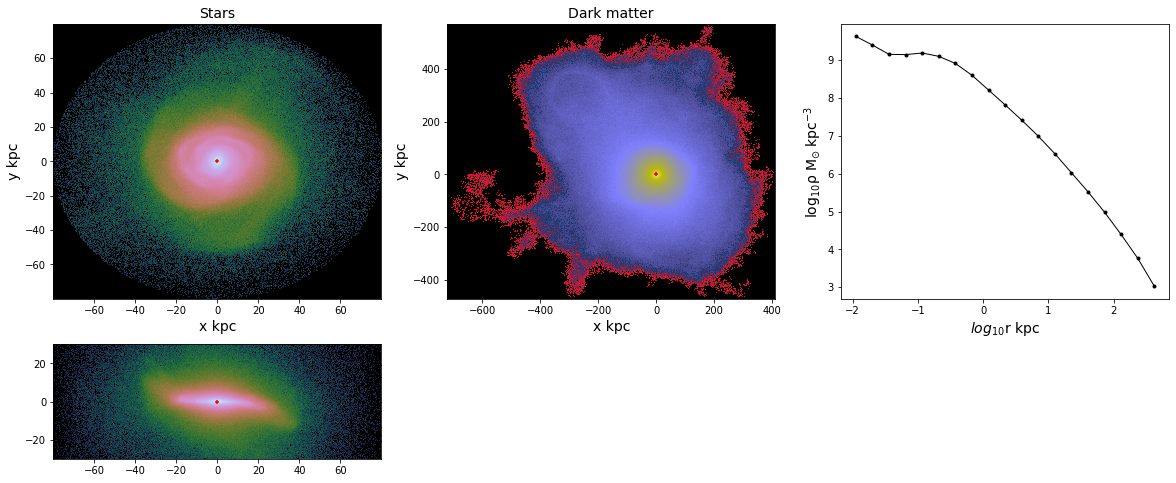

In [4]:
rstar2d = np.sqrt(poss[:,0]**2 + poss[:,1]**2)
cuts = (rstar2d<=80)&(np.abs(poss[:,2])<=30)
Hsf,_xsf,_ysf,boxsf = la.StellarDensity2D(poss[:,0][cuts],poss[:,1][cuts],masss[cuts],
                                          npix = [720,720],style='SD')
Hse,_xse,_yse,boxse = la.StellarDensity2D(poss[:,0][cuts],poss[:,2][cuts],masss[cuts],
                                          npix = [720,int(720/2)],style='SD')

Hdm,_xdm,_ydm,boxdm = la.StellarDensity2D(pos[:,0],pos[:,1],mass,npix = [720,720],style='SD')
    

plt.figure(figsize=(20,8))
    
ax1=plt.subplot(3,3,(1,4))
ax1.patch.set_facecolor('black')
extentsf = _xsf.min(),_xsf.max(),_ysf.min(),_ysf.max()
plt.imshow(np.log10(Hsf).T,cmap='cubehelix',extent=extentsf,aspect='auto',origin='lower',interpolation='none')
plt.scatter(0,0,s=20,c='r',marker='+')
#plt.title('Au-%s'%nhalo,fontsize=14)
plt.title('Stars',fontsize=14)
plt.xlabel('x kpc',fontsize=14)
plt.ylabel('y kpc',fontsize=14)
    
ax2=plt.subplot(3,3,7)
ax2.patch.set_facecolor('black')
extentse = _xse.min(),_xse.max(),_yse.min(),_yse.max()
plt.imshow(np.log10(Hse).T,cmap='cubehelix',extent=extentse,aspect='auto',origin='lower',interpolation='none')
plt.scatter(0,0,s=20,c='r',marker='+')

ax3=plt.subplot(3,3,(2,5))
ax3.patch.set_facecolor('black')
extentdm = _xdm.min(),_xdm.max(),_ydm.min(),_ydm.max()
plt.imshow(np.log10(Hdm).T,cmap='gist_stern',extent=extentdm,aspect='auto',origin='lower',interpolation='none')
plt.scatter(0,0,s=10,c='r',marker='+')
plt.title('Dark matter',fontsize=14)
plt.xlabel('x kpc',fontsize=14)
plt.ylabel('y kpc',fontsize=14)
    
plt.subplot(3,3,(3,6))
r3dm = np.sqrt(pos[:,0]**2 + pos[:,1]**2 + pos[:,2]**2)
r3min,r3max=np.log10(r3dm).min(),np.log10(r3dm).max()
r3dml = np.log10(r3dm)
DR = np.linspace(r3min,r3max,20)
DRn = 10**DR
rho_ = []
for i,j in enumerate(DR):
    if i==len(DR)-1:continue
    sel = (DR[0]<=r3dml)&(r3dml<DR[i+1])
    vol = (4./3.)*np.pi*(DRn[i+1]**3 - DRn[0]**3)
    rho_.append(np.sum(mass[sel])/vol)

plt.plot(DR[:-1],np.log10(rho_),lw=1,marker='.',c='k')
plt.ylabel(r'$\rm log_{10} \rho\; M_{\odot}\;kpc^{-3}}$',fontsize=14)
plt.xlabel(r'$log_{10}$r kpc',fontsize=14)
#print(DR,rho)
    
plt.subplots_adjust(hspace=0.4)
#plt.savefig('plots/profiles_Au%s.pdf'%nhalo)
plt.show()
plt.close()

In [5]:
print('IDhalo: Au-%s'%nhalo)
print('Nsnap: %s'%nsnap)
print('R200: %.3f kpc'%Rvir)
print('M200: %.3f Msun'%np.log10(Mvir))
print('Ngas: %e '%Npart[0])
print('Ndm: %e '%Npart[1])
print('Nstar: %e '%Npart[4])
print('Ntot: %e '%(np.sum(Npart)-1))
print('\nTEST NaN: ',(np.isnan(mass)).any(),(np.isnan(pos)).any(),(np.isnan(pos[:,1])).any())

IDhalo: Au-21
Nsnap: 63
R200: 349.252 kpc
M200: 12.320 Msun
Ngas: 1.179226e+07 
Ndm: 3.150347e+07 
Nstar: 1.910787e+07 
Ntot: 6.240359e+07 

TEST NaN:  False False False


In [6]:
print(np.sum(mass), mass[0], len(pos), len(mass))
print(pos.shape, mass.shape)
M_tot = np.sum(mass)
DMmass = np.max(mass)
print('massDM partcile   %s Msun'%DMmass)
#selecting 1million random particles
'''ind = np.arange(0,len(mass),1,dtype=int)
sel = np.random.choice(ind, 1000000, replace=False).astype(int)
pos,mass = pos[sel],mass[sel]
potdm=potdm[sel]
 
Mfac = M_tot/np.sum(mass)
mass = mass*Mfac'''

rr = np.sqrt((pos[:,0]**2) + (pos[:,1]**2) + (pos[:,2]**2))
#cutr2=rr<=Rvir
#pos,mass,rr = pos[cutr2],mass[cutr2],rr[cutr2]
#potdm=potdm[cutr2]

binrad = 200#int(ss.gaussian_kde(rr).scotts_factor()*len(rr))

rrmin,rrmax=np.nanmin(np.log10(rr)),np.nanmax(np.log10(rr))
r,rho = return_density(np.log10(rr),weights= DMmass, rangevals=[rrmin, rrmax],bins=binrad)
print(rrmin,rrmax,Rvir)
print('\nTEST NaN: ',(np.isnan(rho)).any())


1909809391933.1172 60622.19921875 31503466 31503466
(31503466, 3) (31503466,)
massDM partcile   60622.19921875 Msun
-1.9485473872634727 2.8768124574940486 349.25210558595916

TEST NaN:  False


In [7]:
print(pos.shape, mass.shape)

(31503466, 3) (31503466,)


In [8]:
#r, rho = halo_st.density_profile(nbins=100, rmin=0, rmax=600)
R,D,M,P = makemodel_empirical(r, rho, "Au{}_table.txt".format(nhalo))
print('\nTEST NaN: ',(np.isnan(R)).any(),(np.isnan(D)).any(),(np.isnan(M)).any(),(np.isnan(P)).any())
print(type(M[0]))

! Scaling:  R= 732.401218017244   M= 1.0
1.0 5.239633723326549e-13 5.239633723326551e-13 5.23963372332655e-13

TEST NaN:  False False False False
<class 'numpy.float64'>


In [9]:
config="""
---
id: sphereSL
parameters :
  numr: %s
  rmin: %s
  rmax: %s
  Lmax: 6
  nmax: 20
  modelname: %s_table.txt
...
"""%(len(R),round(np.nanmin(R),3), round(np.nanmax(R),3),'Au'+str(nhalo))
print(config)


---
id: sphereSL
parameters :
  numr: 200
  rmin: 0.012
  rmax: 732.401
  Lmax: 6
  nmax: 20
  modelname: Au21_table.txt
...



In [10]:
# Construct the basis instances
#
basis = pyEXP.basis.Basis.factory(config)

# Prints info from Cache
#basis.cacheInfo('.slgrid_sph_cache')


lrmin = np.log10(np.nanmin(R))
lrmax = np.log10(np.nanmax(R))
rnum  = len(R) 
basis_grid = basis.getBasis(lrmin, lrmax, rnum)


r = np.linspace(lrmin, lrmax, rnum)
r = np.power(10.0, r)

'''
for l in range(3):
    for n in range(5):
        plt.semilogx(r, basis_grid[l][n], '-', label="n={}".format(n))
    plt.xlabel('r')
    plt.ylabel('potential')
    plt.title('l={}'.format(l))
    plt.legend()
    #plt.savefig('/mnt/home/nico/projects/cosmo_wakes/pyEXP_ex/m12i_test_empirical_basis_{}.png'.format(l), bbox_inches='tight
    plt.show()'''

'\nfor l in range(3):\n    for n in range(5):\n        plt.semilogx(r, basis_grid[l][n], \'-\', label="n={}".format(n))\n    plt.xlabel(\'r\')\n    plt.ylabel(\'potential\')\n    plt.title(\'l={}\'.format(l))\n    plt.legend()\n    #plt.savefig(\'/mnt/home/nico/projects/cosmo_wakes/pyEXP_ex/m12i_test_empirical_basis_{}.png\'.format(l), bbox_inches=\'tight\n    plt.show()'

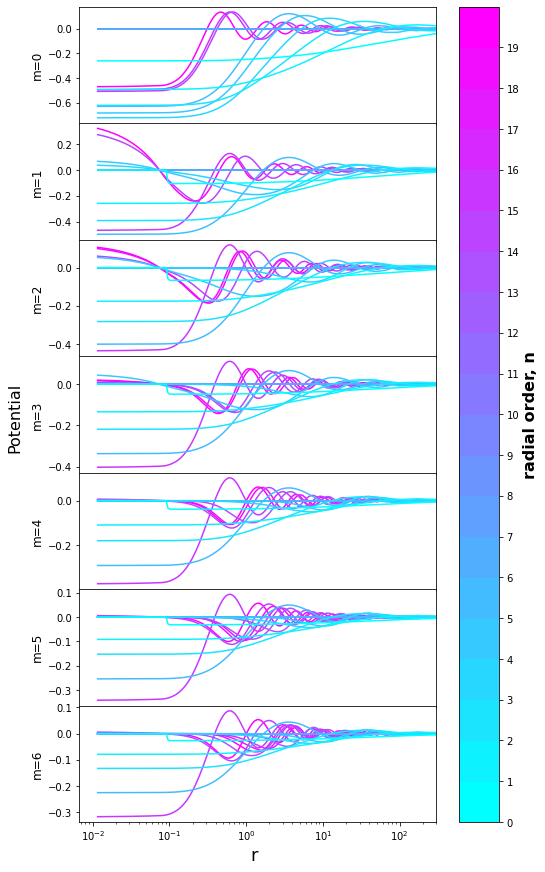

In [11]:
Nmax,lmax=20,6+1
colors =plt.get_cmap('cool', Nmax)
fig, ax = plt.subplots(nrows=lmax, ncols=1,figsize=(8,15))
plt.subplots_adjust(hspace=0)
for l in range(lmax):
    #plt.subplot(4,1,m+1)
    #ax=fig.add_subplot(4,1,m+1)
    for n in range(0,Nmax):
        ax[l].semilogx(r, basis_grid[l][n],c=colors(n),label='n = %s'%n,zorder=Nmax-n)
        ax[l].set_ylabel('m=%s'%l,fontsize=12)
        ax[l].set_xlim(0,300)
        if l!=lmax-1:ax[l].set_xticks([])

#plt.legend(title='radial order',fontsize=14,title_fontsize=18)

norm = mpl.colors.Normalize(vmin=0, vmax=Nmax)
sm = plt.cm.ScalarMappable(cmap=colors, norm=norm)
sm.set_array([])  
#cbar_ax = fig.add_axes([0.5, 0.15, 0.5, 0.7])

cb=plt.colorbar(sm,ax=ax.ravel().tolist(), ticks=np.arange(0, Nmax, 1))
cb.set_label(label='radial order, n', size=16, weight='bold')
plt.xlabel('r ',fontsize=18)

fig.text(0.00, 0.5, 'Potential', va='center', rotation='vertical',fontsize=16)

#plt.subplots_adjust(hspace=0.1)
plt.show()
plt.close()

---

## Test Makemodel_Empirical vs Auriga

In [12]:
rbord = np.argsort(rr)
rb,mb,pwau = rr[rbord],mass[rbord],potdm[rbord]
posb = pos[rbord]
ran = (rb<=r[-1])
rb,mb,pwau = rb[ran],mb[ran],pwau[ran] #Datos directamente de Auriga
mbacc = np.cumsum(mb)


In [13]:
#mfac = 1/mbacc[-1]
km2kpc = 3.24078e-17
rfac,dfac,mfac,pfac=1.0, 5.239633723326549e-13, 5.239633723326551e-13, 5.23963372332655e-13

Text(0.5, 0, 'R')

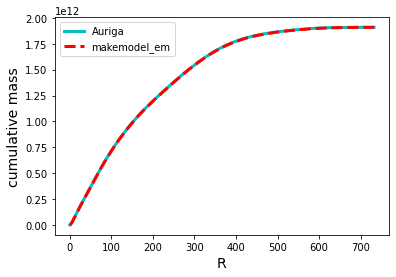

In [14]:
plt.subplot(111)
#plt.plot(rbins,Macc,color='k',label='return_density',lw=5)#/Macc[-1]
plt.plot(rb,mbacc,color='c',label='Auriga',lw=3,ls='-')#/mbacc[-1]
plt.plot(R, M/mfac,c='r',ls='--', label='makemodel_em',lw=3)
plt.legend()
plt.ylabel('cumulative mass',fontsize=14)
plt.xlabel('R',fontsize=14)
#plt.savefig('plots/CumMassMakemodel_em.pdf')

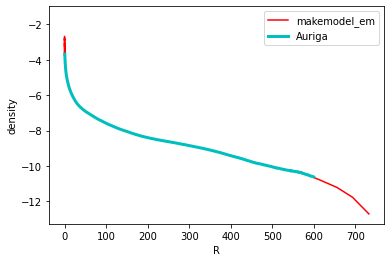

In [15]:
rsd,ddm=empirical_density_profile(posb,mb)

plt.subplot(111)
plt.plot(R, np.log10(D), label='makemodel_em',color='r')
plt.plot(rsd,np.log10(ddm*dfac),color='c',label='Auriga',lw=3,ls='-')
#plt.plot(rbins,np.log10(dreturn*(2*np.pi/np.sum(dm))),c='r',ls='--',label='return_density')

plt.ylabel('density')
plt.xlabel('R')
plt.legend()

Text(0.5, 0, 'R')

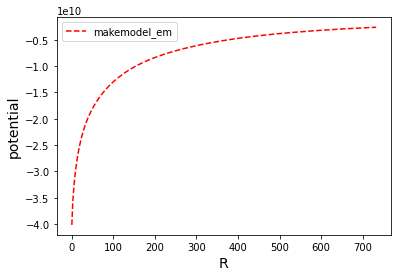

In [16]:
plt.subplot(111)

#plt.plot(rb,pwau_,color='g',label='Auriga',lw=3)
#plt.plot(rbins,Pwacc,color='k',label='return_density')
plt.plot(R, P/pfac,c='r',ls='--', label='makemodel_em')
plt.legend()
plt.ylabel('potential',fontsize=14)
plt.xlabel('R',fontsize=14)

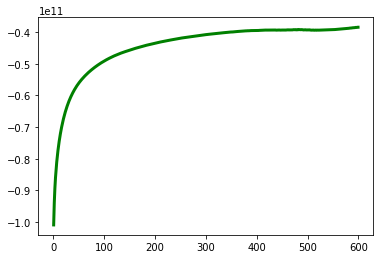

In [17]:
G_=4.300917270036279e-06#43009.17270036279#
potsph = empirical_potencial_profile(posb,(pwau/G_ ))

plt.plot(potsph[0],potsph[1],color='g',label='Auriga',lw=3)

0.01878828518554888


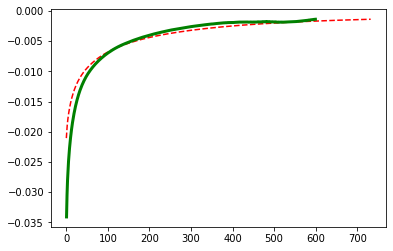

In [18]:
c=np.abs(P[-1]-potsph[1][-1]*pfac)
print(c)
plt.plot(R, P,c='r',ls='--', label='makemodel_em')
plt.plot(potsph[0],(potsph[1]*pfac)+c,color='g',label='Auriga',lw=3)

In [19]:
mfac

5.239633723326551e-13

---

In [20]:
coef = basis.createFromArray(mass=mass, pos=pos, time=3.)
#
print("Time=", coef.time, " geometry=", coef.geometry)
print("Shape=", coef.data.shape)

Time= 3.0  geometry= sphere
Shape= (28, 20)


In [21]:
from schwimmbad import SerialPool,MultiPool
def GetFields(coords):
    dens0,potl0,dens,potl,fx,fy,fz = basis.getFields(x=coords[0],y=coords[1],z=coords[2])
    return dens0,dens,potl0,potl

pool = SerialPool()
Fields = np.array(list(pool.map(GetFields, pos )))

Dmon,Dnmon,Pmon,Pnmon=[],[],[],[]
for xi,yi,zi in DatDM['pos']:
    dens0,potl0,dens,potl,fx,fy,fz = basis.getFields(x=xi,y=yi,z=zi)
    Dmon.append(dens0)
    Dnmon.append(dens)
    Pmon.append(potl0)
    Pnmon.append(potl)

In [22]:
den0, den1,pot0,pot1 = np.array(Fields[:,0]),np.array(Fields[:,1]),np.array(Fields[:,2]),np.array(Fields[:,3])

In [23]:
Npx=50

#potdm = DatDM['pot']
#pos = DatDM['pos'] #part_rot[not_in_subs]
#mass = DatDM['mass']  #part['dark']['mass'][not_in_subs]
#rr = np.sqrt(pos[:,0]**2 + pos[:,1]**2 + pos[:,2]**2)

Hden,Hpot,Hpotmed,Hpotmed_ = np.zeros((Npx,Npx)),np.zeros((Npx,Npx)),np.zeros((Npx,Npx)),np.zeros((Npx,Npx))
den_mon,den_nonmon = np.zeros((Npx,Npx)),np.zeros((Npx,Npx))
pot_mon,pot_nonmon = np.zeros((Npx,Npx)),np.zeros((Npx,Npx))
xb,yb=np.linspace(pos[:,0].min(), pos[:,0].max(),Npx),np.linspace(pos[:,1].min(), pos[:,1].max(),Npx)
dx,dy= xb[1]-xb[0],yb[1]-yb[0]
xgrid, ygrid = np.meshgrid(xb, yb)

rbord = np.argsort(rr)
rb,mb = rr[rbord],mass[rbord]
rbord1=np.argsort(rbord)
mbacc = np.cumsum(mb)
Pot_au=  ((-mbacc/rb) - (np.sum(mb/rb)-np.cumsum(mb/rb)))[rbord1]

for j in range(yb.size -1):
    for i in range(xb.size-1):
        la.PrintPercent((Npx*j)+i,Npx**2)
        sel = (xb[i]<=pos[:,0])&(pos[:,0]<=xb[i+1]) & (yb[j]<=pos[:,1])&(pos[:,1]<=yb[j+1])
        if len(pos[:,2][sel])>0:
            dz = np.nanmax(pos[:,2][sel])-np.nanmin(pos[:,2][sel])
            Hden[j][i] = np.sum(mass[sel])/(dx*dy*dz)
            den_mon[j][i],den_nonmon[j][i]=np.median(den0[sel]),np.median(den1[sel])
            
            Hpot[j][i] = np.sum(Pot_au[sel])/(dx*dy*dz)#potdm
            Hpotmed[j][i] = np.median(Pot_au[sel])#potdm
            Hpotmed_[j][i] = np.median(potdm[sel]/G_)#potdm
            pot_mon[j][i],pot_nonmon[j][i]=np.median(pot0[sel]),np.median(pot1[sel])
        else: pass


In [27]:
Hpotmed_[20:30]

array([[ 0.00000000e+00, -3.67521492e+10, -3.68735931e+10,
        -3.70178174e+10, -3.71945693e+10, -3.73483919e+10,
        -3.74890142e+10, -3.76382792e+10,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -3.89457892e+10, -3.91305117e+10, -3.93352591e+10,
        -3.97090729e+10, -4.00358364e+10, -4.04117065e+10,
        -4.06777253e+10, -4.09868926e+10, -4.15100550e+10,
        -4.20161516e+10, -4.24791397e+10, -4.32264222e+10,
        -4.41202867e+10, -4.54267413e+10, -4.67479275e+10,
        -4.84737694e+10, -5.06884823e+10, -5.31931914e+10,
        -5.60704556e+10, -5.70319547e+10, -5.44846419e+10,
        -5.14036604e+10, -4.88420956e+10, -4.68493521e+10,
        -4.51151544e+10, -4.36743099e+10, -4.27246270e+10,
        -4.18288115e+10, -4.11835004e+10, -4.06864662e+10,
        -4.01625554e+10, -3.97090784e+10, -3.92731721e+10,
        -3.88811173e+10, -3.85214229e+10, -3.82107988e+10,
        -3.79405530e+10,  0.00000000e+00],
       [ 0.00

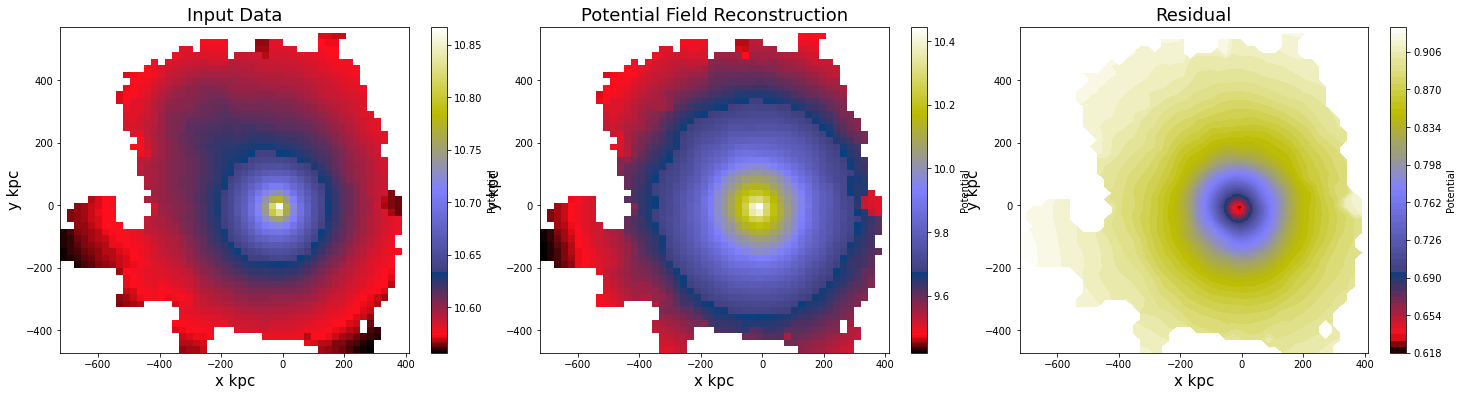

In [38]:
km2kpc=3.24078e-17
G= 6.674*1e-11 #m3⋅kg−1⋅s−2
m2kpc, kg2Msun = 3.2408*1e-20,5e-31
G=G*(m2kpc**3) /kg2Msun # kpc3 Msun-1 s-2
mask=Hpotmed_/Hpotmed_

Hpot_= np.log10(np.abs( Hpotmed_))#* (rb[-1]/(mbacc[-1]) )    ))

fig, ax = plt.subplots(1, 3, figsize=(25,6))
extent = xb.min(),xb.max(),yb.min(),yb.max()
im = ax[0].imshow(Hpot_,extent=extent,aspect='auto',origin='lower',interpolation='none',cmap='gist_stern')
plt.colorbar(im, ax=ax[0],label='Potential')
#im.set_clim(7,12)

ax[0].set_title('Input Data',fontsize=18)
#*(rbins[-1]/(Macc[-1]) ) 
#im2 = ax[1].contourf(xgrid, ygrid, np.log10(np.abs(den_mon + den_nonmon)),40,cmap='gist_stern')
im2 = ax[1].imshow(np.log10(np.abs(pot_mon + pot_nonmon)),extent=extent,aspect='auto',origin='lower',interpolation='none',cmap='gist_stern')
plt.colorbar(im2, ax=ax[1],label='Potential')
#im2.set_clim(im.get_clim()[0],im.get_clim()[1])
ax[1].set_title('Potential Field Reconstruction',fontsize=18)


potresidual = (Hpotmed_ - (pot_mon + pot_nonmon))/Hpotmed_

#im3 = ax[2].imshow(denmask,extent=extent,aspect='auto',origin='lower',interpolation='none',cmap='gist_stern')
im3 = ax[2].contourf(xgrid, ygrid, potresidual,50,cmap='gist_stern')
plt.colorbar(im3, ax=ax[2],label='Potential')
#im3.set_clim(7,12)
for i_ in [0,1,2]:
    ax[i_].set_xlabel('x kpc',fontsize=15)
    ax[i_].set_ylabel('y kpc',fontsize=15)
plt.subplots_adjust(wspace=0.1)
ax[2].set_title('Residual',fontsize=18)
plt.savefig('plots/PotEXP_Au%s.png'%str(nhalo))
plt.show()

plt.close()

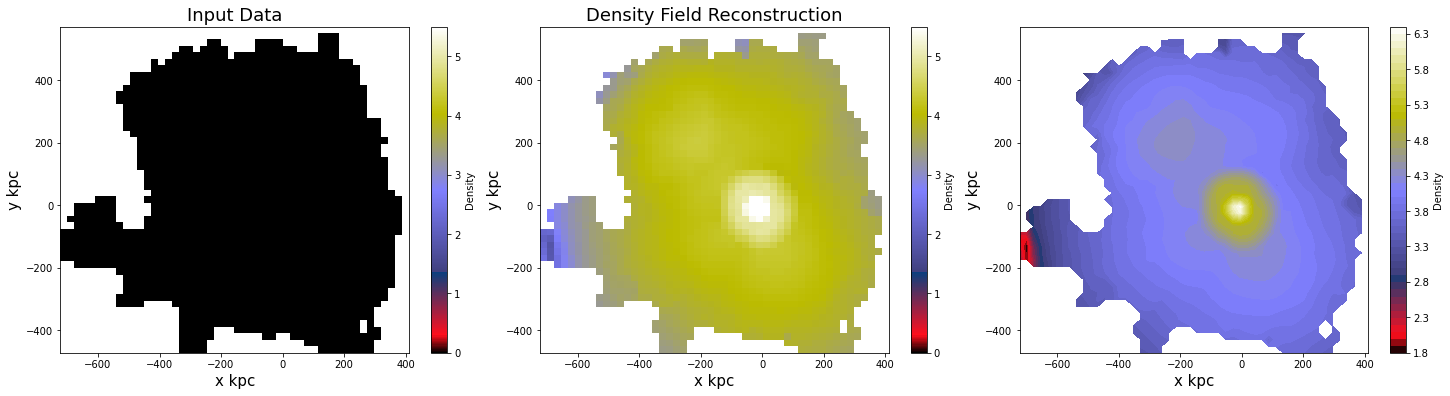

In [26]:
dm = (4/3)*np.pi*rho*r**3
Macc = np.cumsum(dm)

fig, ax = plt.subplots(1, 3, figsize=(25,6))
extent = xb.min(),xb.max(),yb.min(),yb.max()
im = ax[0].imshow(np.log10( Hden*(r[-1]**2/Macc[-1]) ),extent=extent,aspect='auto',origin='lower',interpolation='none',cmap='gist_stern')
plt.colorbar(im, ax=ax[0],label='Density')
ax[0].set_title('Input Data',fontsize=18)
im.set_clim(0,5.5)
#im2 = ax[1].contourf(xgrid, ygrid, np.log10(np.abs(den_mon + den_nonmon)),40,cmap='gist_stern')
im2 = ax[1].imshow(np.log10(np.abs(den_mon + den_nonmon)),extent=extent,aspect='auto',origin='lower',interpolation='none',cmap='gist_stern')
plt.colorbar(im2, ax=ax[1],label='Density')
ax[1].set_title('Density Field Reconstruction',fontsize=18)
im2.set_clim(0,5.5)
maskden = Hden==0
denmask =  np.copy(np.log10(np.abs(den_mon + den_nonmon)))
denmask[maskden] =  np.nan
#im3 = ax[2].imshow(denmask,extent=extent,aspect='auto',origin='lower',interpolation='none',cmap='gist_stern')
im3 = ax[2].contourf(xgrid, ygrid, denmask,50,cmap='gist_stern')
plt.colorbar(im3, ax=ax[2],label='Density')

for i_ in [0,1,2]:
    ax[i_].set_xlabel('x kpc',fontsize=15)
    ax[i_].set_ylabel('y kpc',fontsize=15)
plt.subplots_adjust(wspace=0.1)
plt.show()
plt.close()